In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [79]:
fees= pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request= pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [80]:
cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [81]:
cr= cash_request.copy()
cr=cr[['amount','created_at', 'user_id', 'deleted_account_id', 'transfer_type']]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [82]:
cr.fillna({'user_id':cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [83]:
cr['created_at']=pd.to_datetime(cr['created_at'])
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873+00:00,804.0,regular
1,100.0,2019-12-10 19:50:12.347780+00:00,231.0,regular
2,100.0,2019-12-10 19:13:35.825460+00:00,191.0,regular
3,99.0,2019-12-10 19:16:10.880172+00:00,761.0,regular
4,100.0,2020-05-06 09:59:38.877376+00:00,7686.0,regular


In [84]:
cr['created_at']=cr['created_at'].dt.tz_localize(None)
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873,804.0,regular
1,100.0,2019-12-10 19:50:12.347780,231.0,regular
2,100.0,2019-12-10 19:13:35.825460,191.0,regular
3,99.0,2019-12-10 19:16:10.880172,761.0,regular
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular


In [85]:
cr['Month']=cr['created_at'].dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Month
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05


In [86]:
cr['Cohort']=cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Month,Cohort
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05


In [87]:
# calculate the number of the unique customers in each cohort
cohort_initial_sizes= cr.groupby('Cohort').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()
cohort_initial_sizes

,Cohort,Number_of_initial_customers
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [88]:
cohort_monthly_sizes= cr.groupby(['Cohort','Month']).agg(Number_of_customers=('user_id', 'nunique')).reset_index()
cohort_monthly_sizes

,Cohort,Month,Number_of_customers
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [89]:
cohort_cash_monthly= cr.groupby(['Cohort','Month']).agg(Num_requests=('user_id', 'count')).reset_index()
cohort_cash_monthly

,Cohort,Month,Num_requests
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [90]:
# calculate customer retention rate (unique customers per cohort in each month/initial customers in the cohort)
customers_retention= cohort_monthly_sizes.pivot(index='Cohort' , columns='Month' , values='Number_of_customers')
customers_retention= customers_retention.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

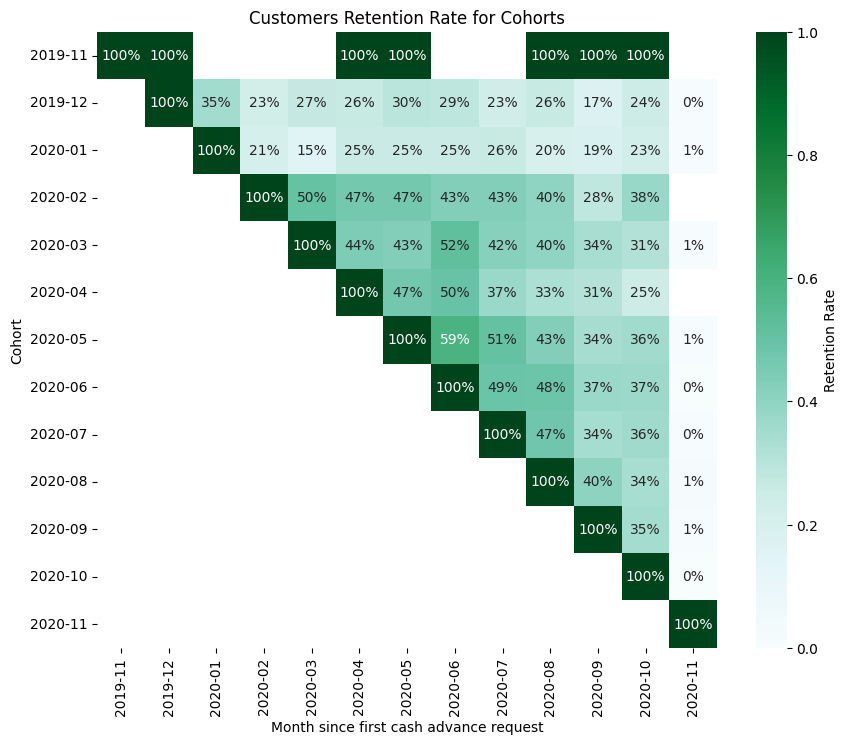

In [91]:
# Show the retention rate with heat map 
plt.figure(figsize=(10, 8))
plt.title('Customers Retention Rate for Cohorts')
sns.heatmap(data=customers_retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cmap='BuGn',
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

Text(95.72222222222221, 0.5, 'Cohort')

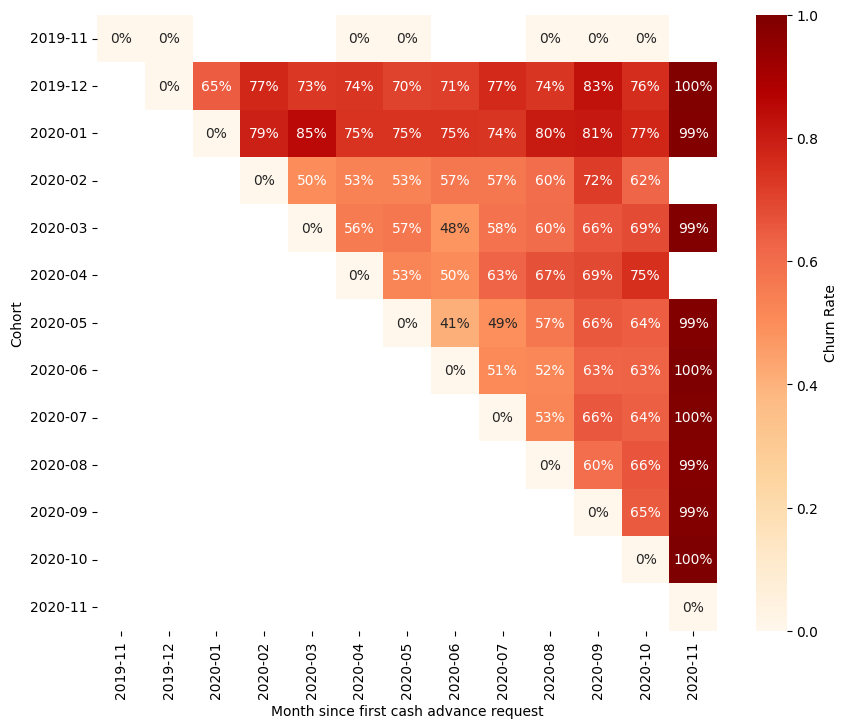

In [92]:
# calculate Churn Rate 
# Churn_rate= 1- retention_rate
churn_rate= 1- customers_retention

# plot the Churn rate 
plt.figure(figsize=(10, 8))
sns.heatmap(data=churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0 ,
            vmax=1.0,
            cmap='OrRd',
            cbar_kws={'label':'Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')

In [93]:
# calculate the initial number of cash advance requests in each cohort
cohort_cash_initial= cohort_cash_monthly.groupby('Cohort').first().reset_index().rename(columns={'Num_requests':'Num_initial_requests'})
cohort_cash_initial

,Cohort,Month,Num_initial_requests
0,2019-11,2019-11,1
1,2019-12,2019-12,288
2,2020-01,2020-01,117
3,2020-02,2020-02,97
4,2020-03,2020-03,99
5,2020-04,2020-04,264
6,2020-05,2020-05,478
7,2020-06,2020-06,1934
8,2020-07,2020-07,1996
9,2020-08,2020-08,993


In [94]:
# Request Retention Rate (for Cohorts in Each Month/ Number of Initial Request of Cohort)
retention_request= cohort_cash_monthly.pivot(index='Cohort', columns='Month', values='Num_requests')
retention_request= retention_request.div(cohort_cash_initial.set_index('Cohort')['Num_initial_requests'], axis=0)
retention_request

Month,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohort,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


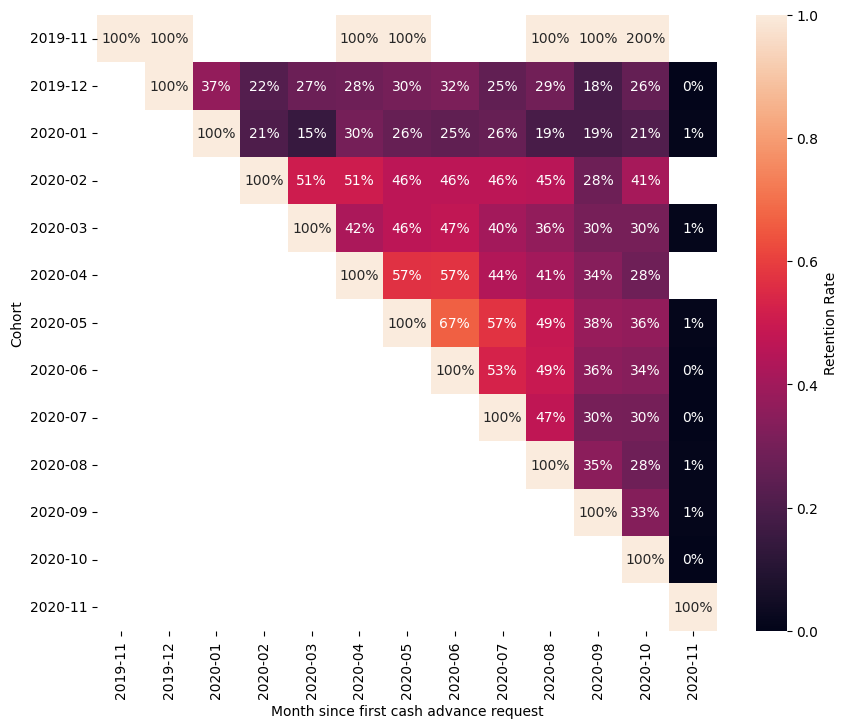

In [95]:
plt.figure(figsize=(10,8))
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(data=retention_request,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

In [96]:
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [97]:
def evaluate_regression_models(df, feature_col, target_col, poly_degrees=[1, 2, 3, 4, 5], 
                              alpha_values=[0.001, 0.01, 0.1, 1, 1.1, 1.5, 2], 
                              n_splits=5, random_state=42, test_size=0.2, extrapolation_size=0.2, l1_ratio=0.5):
    """
    Evaluate Ridge, Lasso, ElasticNet, and Linear Regression models with polynomial features.
    Includes 95% confidence intervals in the plots.

    Parameters:
    - df: pandas DataFrame, the dataset containing the feature and target columns.
    - feature_col: str, the name of the feature column.
    - target_col: str, the name of the target column.
    - poly_degrees: list, polynomial degrees to test.
    - alpha_values: list, regularization strengths for Ridge, Lasso, and ElasticNet.
    - n_splits: int, number of folds for cross-validation.
    - random_state: int, random seed for reproducibility.
    - test_size: float, proportion of the dataset to include in the test split.
    - extrapolation_size: float, proportion of the dataset to include in the extrapolation split.
    - l1_ratio: float, the mixing parameter for ElasticNet (0 <= l1_ratio <= 1).

    Returns:
    - None (plots and prints evaluation metrics).
    """
    
    # Remove NaN values
    df_train = df.dropna()

    # Convert to numpy arrays
    X = np.array(df_train[feature_col]).reshape(-1, 1)
    y = np.array(df_train[target_col])

    # Split dataset into interpolation and extrapolation sets
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=extrapolation_size, 
                                                              random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=test_size, 
                                                        shuffle=True, random_state=random_state)

    # K-Fold Cross Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Loop through each polynomial degree
    for degree in poly_degrees:
        best_ridge_alpha, best_lasso_alpha, best_elastic_alpha = None, None, None
        best_ridge_model, best_lasso_model, best_elastic_model, best_linear_model = None, None, None, None
        best_ridge_mse, best_lasso_mse, best_elastic_mse, best_linear_mse = float('inf'), float('inf'), float('inf'), float('inf')

        # Loop through different alpha values for Ridge, Lasso, and ElasticNet
        for alpha in alpha_values:
            # Ridge Regression
            ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
            ridge_preds = cross_val_predict(ridge_model, X_train, y_train, cv=kf)
            ridge_mse = mean_squared_error(y_train, ridge_preds)

            if ridge_mse < best_ridge_mse:
                best_ridge_mse = ridge_mse
                best_ridge_alpha = alpha
                best_ridge_model = ridge_model

            # Lasso Regression
            lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=10000))
            lasso_preds = cross_val_predict(lasso_model, X_train, y_train, cv=kf)
            lasso_mse = mean_squared_error(y_train, lasso_preds)

            if lasso_mse < best_lasso_mse:
                best_lasso_mse = lasso_mse
                best_lasso_alpha = alpha
                best_lasso_model = lasso_model

            # ElasticNet Regression
            elastic_model = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000))
            elastic_preds = cross_val_predict(elastic_model, X_train, y_train, cv=kf)
            elastic_mse = mean_squared_error(y_train, elastic_preds)

            if elastic_mse < best_elastic_mse:
                best_elastic_mse = elastic_mse
                best_elastic_alpha = alpha
                best_elastic_model = elastic_model

        # Linear Regression (No Regularization)
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_preds = cross_val_predict(linear_model, X_train, y_train, cv=kf)
        best_linear_mse = mean_squared_error(y_train, linear_preds)
        best_linear_model = linear_model

        # Train the best models for this degree
        best_ridge_model.fit(X_interp, y_interp)
        best_lasso_model.fit(X_interp, y_interp)
        best_elastic_model.fit(X_interp, y_interp)
        best_linear_model.fit(X_interp, y_interp)

        # Predictions
        ridge_y_predict_interp = best_ridge_model.predict(X_interp)
        ridge_y_predict_extra = best_ridge_model.predict(X_extrap)
        lasso_y_predict_interp = best_lasso_model.predict(X_interp)
        lasso_y_predict_extra = best_lasso_model.predict(X_extrap)
        elastic_y_predict_interp = best_elastic_model.predict(X_interp)
        elastic_y_predict_extra = best_elastic_model.predict(X_extrap)
        linear_y_predict_interp = best_linear_model.predict(X_interp)
        linear_y_predict_extra = best_linear_model.predict(X_extrap)

        # Compute residuals for confidence intervals
        ridge_residuals = y_interp - ridge_y_predict_interp
        lasso_residuals = y_interp - lasso_y_predict_interp
        elastic_residuals = y_interp - elastic_y_predict_interp
        linear_residuals = y_interp - linear_y_predict_interp

        # Standard deviation of residuals
        ridge_std = np.std(ridge_residuals)
        lasso_std = np.std(lasso_residuals)
        elastic_std = np.std(elastic_residuals)
        linear_std = np.std(linear_residuals)

        # 95% confidence interval (1.96 * std)
        ridge_ci = 1.96 * ridge_std
        lasso_ci = 1.96 * lasso_std
        elastic_ci = 1.96 * elastic_std
        linear_ci = 1.96 * linear_std

        # Compute R² Scores for Extrapolation
        R2_ridge_extrap = r2_score(y_extrap, ridge_y_predict_extra)
        R2_lasso_extrap = r2_score(y_extrap, lasso_y_predict_extra)
        R2_elastic_extrap = r2_score(y_extrap, elastic_y_predict_extra)
        R2_linear_extrap = r2_score(y_extrap, linear_y_predict_extra)

        # Plot Results
        plt.figure(figsize=(24, 5))

        # Ridge Plot
        plt.subplot(1, 4, 1)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, ridge_y_predict_interp, label='Ridge (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.ravel(), ridge_y_predict_interp - ridge_ci, ridge_y_predict_interp + ridge_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, ridge_y_predict_extra, label='Ridge (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.ravel(), ridge_y_predict_extra - ridge_ci, ridge_y_predict_extra + ridge_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'Ridge (Degree {degree}, α={best_ridge_alpha})')
        plt.legend()

        # Lasso Plot
        plt.subplot(1, 4, 2)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, lasso_y_predict_interp, label='Lasso (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.ravel(), lasso_y_predict_interp - lasso_ci, lasso_y_predict_interp + lasso_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, lasso_y_predict_extra, label='Lasso (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.ravel(), lasso_y_predict_extra - lasso_ci, lasso_y_predict_extra + lasso_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'Lasso (Degree {degree}, α={best_lasso_alpha})')
        plt.legend()

        # ElasticNet Plot
        plt.subplot(1, 4, 3)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, elastic_y_predict_interp, label='ElasticNet (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.ravel(), elastic_y_predict_interp - elastic_ci, elastic_y_predict_interp + elastic_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, elastic_y_predict_extra, label='ElasticNet (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.ravel(), elastic_y_predict_extra - elastic_ci, elastic_y_predict_extra + elastic_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'ElasticNet (Degree {degree}, α={best_elastic_alpha})')
        plt.legend()

        # Linear Regression Plot
        plt.subplot(1, 4, 4)
        plt.scatter(X_train, y_train, label='Train', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation', color='orange', alpha=0.5)
        plt.plot(X_interp, linear_y_predict_interp, label='Linear (Interp)', color='red', linewidth=2)
        plt.fill_between(X_interp.flatten(), linear_y_predict_interp - linear_ci, linear_y_predict_interp + linear_ci, 
                         color='red', alpha=0.2, label='95% CI')
        plt.plot(X_extrap, linear_y_predict_extra, label='Linear (Extrap)', color='gray', linewidth=2)
        plt.fill_between(X_extrap.flatten(), linear_y_predict_extra - linear_ci, linear_y_predict_extra + linear_ci, 
                         color='gray', alpha=0.2)
        plt.title(f'Linear Regression (Degree {degree})')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"Degree {degree}:")
        print(f"  Ridge (α={best_ridge_alpha}, MSE={best_ridge_mse:.4f}), R² Extrapolation={R2_ridge_extrap:.4f}")
        print(f"  Lasso (α={best_lasso_alpha}, MSE={best_lasso_mse:.4f}), R² Extrapolation={R2_lasso_extrap:.4f}")
        print(f"  ElasticNet (α={best_elastic_alpha}, MSE={best_elastic_mse:.4f}), R² Extrapolation={R2_elastic_extrap:.4f}")
        print(f"  Linear Regression (MSE={best_linear_mse:.4f}), R² Extrapolation={R2_linear_extrap:.4f}")
        print()

# Example usage:
# Assuming `df` is your DataFrame and 'Month_Num' and 'Retention_Rate' are your columns
# evaluate_regression_models(df, feature_col='Month_Num', target_col='Retention_Rate')

In [98]:
def evaluate_polynomial_regression(df, feature_col, target_col, poly_degree=[1, 2, 3, 4, 5], random_state=42):
    """
    Trains and evaluates Polynomial Linear Regression models for different degrees.
    Splits data into interpolation and extrapolation sets, computes metrics, and plots results.

    Parameters:
        df (DataFrame): Data containing 'Month_Num' and 'Retention_Rate' columns.
        poly_degree (list): List of polynomial degrees to test.
        random_state (int): Seed for reproducibility.

    Returns:
        Best linear model (Plots results and prints performance metrics)
    """
    df_train = df.dropna()  # Remove NaN values

    # Convert to numpy arrays
    X = np.array(df_train[feature_col]).reshape(-1, 1)
    y = np.array(df_train[target_col])
    
    # Split dataset into 80% interpolation and 20% extrapolation
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True, random_state=random_state)

    best_linear_model = None
    best_linear_mse = float('inf')
    best_degree = 0 
    # Loop through each polynomial degree
    for degree in poly_degree:
        # Create and fit the Linear Regression Model with Polynomial Features
        linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        linear_model.fit(X_train, y_train)  # Train model
    
        # Predictions
        linear_train_preds = linear_model.predict(X_train)
        linear_test_preds = linear_model.predict(X_test)
        
        linear_y_predict_interp = linear_model.predict(X_interp)
        linear_y_predict_extra = linear_model.predict(X_extrap)


        # Compute residual for confidence intervals
        
        linear_residuals = y_interp - linear_y_predict_interp

        # Standard deviation of residuals
        linear_std = np.std(linear_residuals)

        # 95% confidence interval (1.96 * std)
        linear_ci = 1.96 * linear_std
        
    
        # Compute Performance Metrics
        linear_mse_train = mean_squared_error(y_train, linear_train_preds)
        linear_mse_test = mean_squared_error(y_test, linear_test_preds)
        R2_sklearn_train = r2_score(y_train, linear_train_preds)
        R2_sklearn_test = r2_score(y_test, linear_test_preds)
        R2_sklearn_extrap = r2_score(y_extrap, linear_y_predict_extra)
        
        if linear_mse_train < best_linear_mse:
            best_linear_model = linear_model
            best_degree = degree
        # Plot results for this degree
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
        plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
        plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
        plt.plot(X_interp, linear_y_predict_interp, label='Linear Trend (Interpolation)', color='red', linewidth=2)
        plt.plot(X_extrap, linear_y_predict_extra, label='Linear Trend (Extrapolation)', color='gray', linewidth=2)
    
        # Add standard deviation bands
        plt.fill_between(X_interp.flatten(), linear_y_predict_interp - linear_ci, linear_y_predict_interp + linear_ci, color='red', alpha=0.2)
        plt.fill_between(X_extrap.flatten(), linear_y_predict_extra - linear_ci, linear_y_predict_extra + linear_ci, color='gray', alpha=0.2)
    
        plt.title(f'Linear Regression (Degree {degree})')
        plt.legend()
        plt.show()
    
        # Print Performance Metrics
        print(f"Degree {degree}:")
        print(f" - Train MSE: {linear_mse_train:.4f}")
        print(f" - Test MSE: {linear_mse_test:.4f}")
        print(f" - R² Score (Train): {R2_sklearn_train:.4f}")
        print(f" - R² Score (Test): {R2_sklearn_test:.4f}")
        print(f" - R² Score (Extrapolation): {R2_sklearn_extrap:.4f}")
        print("=" * 60)
        
    print(f'The best linear regression model was for  {best_degree} degree')
    return best_linear_model


In [99]:
cohort_2019_12 = retention_request.loc['2019-12']  # Keep double brackets to retain DataFrame structure


df = cohort_2019_12.reset_index()  # Select first two columns dynamically
df.columns = ['Month', 'Retention_Rate']
df = df.iloc[:-1]
# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

,Month,Retention_Rate,Month_Num
0,2019-11-01,NaN,0
1,2019-12-01,1.000000,1
2,2020-01-01,0.368056,2
3,2020-02-01,0.218750,3
4,2020-03-01,0.274306,4
5,2020-04-01,0.284722,5
6,2020-05-01,0.298611,6
7,2020-06-01,0.315972,7
8,2020-07-01,0.250000,8
9,2020-08-01,0.291667,9


In [101]:
print(best_linear_model.named_steps["linearregression"].coef_)
print(best_linear_model.named_steps["linearregression"].intercept_)

[ 0.00000000e+00 -3.92081955e+00  1.77535962e+00 -3.80463239e-01
  3.90418320e-02 -1.54458774e-03]
3.488425925900941


In [102]:
def fourier_transform(X, N=5):
    """Transforms X into Fourier basis functions up to N terms."""
    X = X.flatten()
    features = [np.ones_like(X)]  # Intercept term (bias term a0)
    
    for n in range(1, N + 1):
        features.append(np.sin(n * X))  # Sine terms
        features.append(np.cos(n * X))  # Cosine terms
    
    return np.column_stack(features)

In [103]:
from sklearn.preprocessing import FunctionTransformer

def evaluate_polynomial_regression_fourier(df, feature_col, target_col, poly_degree=[1, 2, 3, 4, 5], N_terms=4, random_state=42):
    """
    Trains and evaluates The Fourier Linear Regression model.
    Splits data into interpolation and extrapolation sets, computes metrics, and plots results.

    Parameters:
        df (DataFrame): Input data.
        feature_col (str): Feature column name.
        target_col (str): Target column name.
        N_terms (int): Number of Fourier terms to use.
        random_state (int): Seed for reproducibility.

    Returns:
        None (Plot the The linear regresssion model with fourrier series)
    """
    df_train = df.dropna()  # Remove NaN values

    # Convert to numpy arrays
    X = np.array(df_train[feature_col]).reshape(-1, 1)
    y = np.array(df_train[target_col])

    # Split dataset into 80% interpolation and 20% extrapolation
    X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True, random_state=random_state)

    # Fourier Features Transformer
    fourier_features = FunctionTransformer(lambda x: fourier_transform(x, N=N_terms), validate=True)
    fourier_model = make_pipeline(fourier_features, LinearRegression())

    # Train Fourier Model
    fourier_model.fit(X_train, y_train)

    # Fourier Predictions
    fourier_train_preds = fourier_model.predict(X_train)
    fourier_test_preds = fourier_model.predict(X_test)
    fourier_y_predict_interp = fourier_model.predict(X_interp)
    fourier_y_predict_extra = fourier_model.predict(X_extrap)

    # Compute Fourier Performance Metrics
    fourier_mse_train = mean_squared_error(y_train, fourier_train_preds)
    fourier_mse_test = mean_squared_error(y_test, fourier_test_preds)
    R2_fourier_train = r2_score(y_train, fourier_train_preds)
    R2_fourier_test = r2_score(y_test, fourier_test_preds)
    R2_fourier_extrap = r2_score(y_extrap, fourier_y_predict_extra)

    print("=== Fourier Regression ===")
    print(f" - Train MSE: {fourier_mse_train:.4f}")
    print(f" - Test MSE: {fourier_mse_test:.4f}")
    print(f" - R² Score (Train): {R2_fourier_train:.4f}")
    print(f" - R² Score (Test): {R2_fourier_test:.4f}")
    print(f" - R² Score (Extrapolation): {R2_fourier_extrap:.4f}")
    print("=" * 60)

In [ ]:
cohort_2020_01 = retention_request.loc['2020-01']
df_2020_01 = cohort_2020_01.reset_index()

df_2020_01.columns = ['Month', 'Retention_Rate']
df_2020_01 = df_2020_01.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_01['Month'] = df_2020_01['Month'].astype(str)  # Convert to string
df_2020_01['Month'] = pd.to_datetime(df_2020_01['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_01['Month_Num'] = (df_2020_01['Month'] - df_2020_01['Month'].min()).dt.days // 30

df_2020_01

In [ ]:
evaluate_polynomial_regression(df_2020_01)

In [ ]:
cohort_2020_02 = retention_request.loc['2020-02']
df_2020_02 = cohort_2020_02.reset_index()

df_2020_02.columns = ['Month', 'Retention_Rate']
df_2020_02 = df_2020_02.iloc[:-1]
# Convert 'Month' from Period to datetime
df_2020_02['Month'] = df_2020_02['Month'].astype(str)  # Convert to string
df_2020_02['Month'] = pd.to_datetime(df_2020_02['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df_2020_02['Month_Num'] = (df_2020_02['Month'] - df_2020_02['Month'].min()).dt.days // 30
df_2020_02['Month_Num'] = df_2020_02['Month_Num'].astype(int)
df_2020_02


In [ ]:
evaluate_polynomial_regression(df_2020_02)

In [ ]:
# Merge datasets using cash_request_id from fees and id from cash_request
merged_df = fees.merge(cash_request, left_on='cash_request_id', right_on='id', how='inner')

# Drop redundant columns (ensure 'id_y' exists before dropping)
if 'id_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=["id_y"])

# Rename columns for clarity
merged_df.rename(columns={"id_x": "fee_id", "cash_request_id": "cash_request_id"}, inplace=True)

#  Correct Column Naming
if 'created_at_y' in merged_df.columns:  # Prefer cash request date
    merged_df['created_at_cash_request'] = merged_df['created_at_y']
    merged_df = merged_df.drop(columns=["created_at_y"])
    if 'created_at_x' in merged_df.columns:  # Use fee date if cash request date is missing
        merged_df['created_at_fees'] = merged_df['created_at_x']
        merged_df = merged_df.drop(columns=["created_at_x"])
else:
    raise KeyError("Column 'created_at' not found in merged dataset")

#  Convert 'created_at_cash_request' to datetime
merged_df['created_at_cash_request'] = pd.to_datetime(merged_df['created_at_cash_request'], errors='coerce')

#  Create Month Column for Cash Request
merged_df['Month_cash_request'] = merged_df['created_at_cash_request'].dt.to_period('M')
merged_df['Month_cash_request'] = merged_df['Month_cash_request'].astype(str)  # Convert to string
merged_df['Month_cash_request'] = pd.to_datetime(merged_df['Month_cash_request'], format='%Y-%m')

merged_df['Month_Num_cash_request'] = ((merged_df['Month_cash_request'] - merged_df['Month_cash_request'].min()).dt.days // 30)

#  Convert 'created_at_fees' to datetime
merged_df['created_at_fees'] = pd.to_datetime(merged_df['created_at_fees'], errors='coerce')

#  Create Month Column for Fees
merged_df['Month_fees'] = merged_df['created_at_fees'].dt.to_period('M')
merged_df['Month_fees'] = merged_df['Month_fees'].astype(str)  # Convert to string
merged_df['Month_fees'] = pd.to_datetime(merged_df['Month_fees'], format='%Y-%m')

merged_df['Month_Num_fees'] = ((merged_df['Month_fees'] - merged_df['Month_fees'].min()).dt.days // 30)

#  Display the merged dataset info
merged_df.info()

In [ ]:
import plotly.express as px 

fig= px.imshow(merged_df.isnull(),
              color_continuous_scale=['gray','green'],
              labels=dict(color='NaN'),
              title='Color Map for the Merged Data Frame(Inner Join)')
fig.update_layout(width=700, height=700)
fig.update_coloraxes(showscale= False)
fig.show()

In [ ]:
merged_df.head()

In [ ]:
# Create 3 group based on the spenditures
bins =[cash_request['amount'].min(), 50, 150, cash_request['amount'].max()]
labels=['Low', 'Medium', 'High']
merged_df['spend_segment'] = pd.cut(cash_request['amount'], bins=bins, labels=labels, include_lowest=True)



# Perform cohort analysis for each spending segment
cohort_pivot_spend = merged_df.pivot_table(index=['Month_cash_request', ],
                                                 columns='spend_segment',
                                                 values='user_id',
                                                 aggfunc='nunique')
cohort_pivot_spend

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot_spend, annot=True, fmt=".1f", cmap="Blues")
plt.title("Cohort Retention by Spend Segment")
plt.xlabel("Months Since First Cash Request")
plt.ylabel("Cohort Month & Spending Segment")
plt.show()

In [ ]:
# Aggregate user-level data

user_features = merged_df.groupby('user_id').agg(
    num_requests=('user_id', 'count'),  # Total requests per user
    avg_amount=('amount', 'mean'),  # Average amount per request
    total_amount=('amount', 'sum'),  # Total borrowed amount
    first_request_month=('Month_cash_request', 'min'),  # First request date
    last_request_month=('Month_cash_request', 'max'),  # Last request date
    fees_paid=('total_amount', 'sum')  # Total fees paid
).reset_index()

# Convert first request month into categorical time periods
user_features['first_request_month'] = pd.to_datetime(user_features['first_request_month'], errors='coerce')
user_features['last_request_month'] = pd.to_datetime(user_features['last_request_month'], errors='coerce')


# Calculate user activity duration in days
user_features['user_lifetime'] = (user_features['last_request_month'] - user_features['first_request_month']).dt.days

# Convert first request month into categorical time periods (YYYY-MM format)
user_features['first_request_month'] = user_features['first_request_month'].dt.to_period('M')

# Classify users into spending segments
def classify_segment(amount):
    if amount < 100:  # Define thresholds based on data distribution
        return 'Low'
    elif amount < 500:
        return 'Medium'
    else:
        return 'High'

user_features['spend_segment'] = user_features['total_amount'].apply(classify_segment)

# Drop unnecessary columns
user_features = user_features.drop(columns=['last_request_month'])

user_features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set The Random Seed
random_seed=42

# Seprate the Features and the Target coulmns
target=user_features['spend_segment']
features=user_features.drop(columns=['user_id','spend_segment', 'first_request_month'])

# Convert datetime to numeric months


# Encode the spend_segment by LbabelEncoder
label_encoder=LabelEncoder()
target=label_encoder.fit_transform(target)

# Scale The Features With StandardScaler 
standard_scaler= StandardScaler()
features= standard_scaler.fit_transform(features)

# Split Data for Interpolationa, Extrapolation, Train and Test
X_interap, X_extrap, y_interap, y_extrap= train_test_split(features, target, test_size=0.3, random_state= random_seed, shuffle=False)
# X_train, X_test, Y_train, Y_test = train_test_split(X_interap, y_interap, test_size=0.2, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_interap, y_interap, test_size=0.3, random_state=random_seed, shuffle=True)

# Create a SVM Model With RBF Kernel
svm_model= SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
cv_scores = cross_val_score(svm_model, features, target, cv=kf, scoring='accuracy')

# Display cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))


svm_model.fit(X_train, y_train)

In [ ]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_model = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()



In [ ]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data 

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


# Classification Report For The Test Data 
y_pred_test = svm_model.predict(X_test)

# Print accuracy
from sklearn.metrics import accuracy_score, classification_report
print('-'*50,'\n','Test')
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix 
cm_svm= confusion_matrix(y_test, y_pred_test)
print(cm_svm)

y_pred_extrap = svm_model.predict(X_extrap)

print('-'*50,'\n','Extrapolation')
print("SVM Model Accuracy:", accuracy_score(y_extrap, y_pred_extrap))
print("Classification Report:\n", classification_report(y_extrap, y_pred_extrap))
cm_svm_extrap= confusion_matrix(y_extrap, y_pred_extrap)
print(cm_svm_extrap)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
# AUC for each class 
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel types
}

# Create SVM model
svm_model = SVC(probability=True)
# Define K-Fold Cross-Validation strategy (Stratified ensures class balance)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implement GridSearchCV with K-Fold CV
grid_search = GridSearchCV(svm_model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=3)


# Fit on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on test data
test_accuracy = best_svm_model.score(X_test, y_test)
print("Test Accuracy of Best Model:", test_accuracy)

In [ ]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_best_model = SVC(kernel='linear', C=100, gamma=0.01, probability=True)
svm_pca_best_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [ ]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data


# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [ ]:
# AUC for each class 
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= best_svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= best_svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Set up the KNN model with n_neighbors= 10 
n_neighbors= 10
knn_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_model.fit(X_train, y_train)



In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
knn_pca_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_knn = 0.02  

# Extract PCA feature limits
x_min_knn, x_max_knn = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("KNN Decision Boundary with PCA")
plt.show()

In [ ]:
pca = PCA(n_components=2)
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data
X_extrap_pca = pca.transform(X_extrap)


# Visualize the descision area
# Define mesh step size
h_knn = 0.02  

# Extract PCA feature limits
x_min_knn, x_max_knn = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, camp='viridis')
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("Classification With KNN , n_neighbors = 10")
plt.show()

In [ ]:
y_pred_test_knn = knn_model.predict(X_test)
y_pred_extrap_knn= knn_model.predict(X_extrap)

print('Classification Report:')
print(classification_report(y_test, y_pred_test_knn))
print(classification_report(y_extrap, y_pred_extrap_knn))

cm_matrix_test = confusion_matrix(y_test,y_pred_test_knn)
print('Confusion Matrix for the test data:')
print(cm_matrix_test)

cm_matrix_extrap = confusion_matrix(y_extrap,y_pred_extrap_knn)
print('Confusion Matrix for the extrapolation data:')
print(cm_matrix_extrap)

# AUC for each class 
lb_knn= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= knn_model.predict_proba(X_test)

y_extrap_bin= lb_knn.fit_transform(y_extrap)
y_pred_prob_extrap= knn_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

In [ ]:
k_values_knn = range(1, 20)
accuracies_knn = []

for k_knn in k_values_knn :
    Knn_model = KNeighborsClassifier(n_neighbors = k_knn)
    scores_knn= cross_val_score(knn_model, X_train , y_train,cv=5)
    accuracies_knn.append(scores_knn.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values_knn, accuracies_knn, marker='o')
plt.title('($k$) Parameter Optimization')
plt.ylabel('average precision')
plt.show()